In [1]:
import pandas as pd
import numpy as np
import os
from utils import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import rcParams
import treeswift, re
import warnings
import re
import random
from collections import Counter
rcParams['font.family'] = 'Helvetica'  

# Suppress warnings from the 'treeswift' package
warnings.filterwarnings("ignore", module="treeswift")

# Create complete SC2 aln

In [2]:
d = '../sarbecovirus_proximal_ancestors/data/SC2like_92bpGARD_050924/SC2_PL_cleaned/'
nrr_fasta = {}
for path in os.listdir(d):
    if 'edit' in path and path.endswith('.fasta') and 'complete' not in path and 'seqRemoved' not in path:
        nrr = int(path.split('NRR')[-1].split('_')[0].split('.')[0])
        nrr_fasta[nrr] = readFASTA(d+path)
complete_fasta = {}
for nrr in sorted(nrr_fasta):
    for key in nrr_fasta[nrr]:
        if key not in complete_fasta:
            complete_fasta[key] = nrr_fasta[nrr][key]
        else:
            complete_fasta[key] += nrr_fasta[nrr][key]

with open(d + 'SC2_complete_hmm.edit.fasta', 'w') as f:
    for key in complete_fasta:
        f.write('>' + key + '\n' + complete_fasta[key] + '\n')

# We only go to 2022 for SC1, and 2024 for SC2. If we change to 2024 for both, need to fix the NRR-plot too

In [3]:
def sequence_identity_relToRef(ref, seq, print_sites=False):
    sites = 0 # where at least one sequence is not a gap
    identical_sites = 0 
    ref = ref.upper()
    seq = seq.upper()
    if len(ref) != len(seq):
        print('Different sequence lengths')
        return
    for i, nt in enumerate(ref):
        # print(ref[i], seq[i])
        if ref[i] in '-N' or seq[i] in '-N':
            continue
        
        sites += 1
        if ref[i] == seq[i]:
            identical_sites += 1

    if print_sites:
        print(sites, identical_sites)
    if sites == 0:
        return 0
    else:
        return identical_sites/sites
    

def read_mcc_tree(tree):
    if (type(tree) != treeswift.Tree) and ((type(tree) != str)):
        raise ValueError('The provided tree must be a treeswift tree object, a path to a tree file, or a newick string')

    if type(tree) is str:
        if os.path.exists(tree):
            tree_d = treeswift.read_tree_nexus(tree)
            tree = tree_d['TREE1']
        else:
            try:
                tree = treeswift.read_tree_newick(tree)
            except:
                raise ValueError('The provided tree path does not exist or the newick string is invalid')
    
    for n in tree.traverse_preorder():
        node_params = (n.node_params)
        rx_comma = re.compile(r'(?:[^,{]|\{[^}]*\})+')
        result = rx_comma.findall(node_params)
        n.node_params = {}
        for param in result:
            key, value = param.split('=')
            key = key.strip('&')
            value = value.replace('"', '')
            if '{' in value:
                value = value.strip('{').strip('}').split(',')
            if type(value) is not list:
                try: 
                    value = float(value)
                except:
                    pass
            else:
                try:
                    value = [float(x) for x in value]
                except:
                    pass
            n.node_params[key] = value
        
        if n.is_leaf():
            n.label = n.label.replace('"', '').replace("'", '')
    # tree_d['TREE1'] = tree
    return tree


def cleanFASTA(fasta):
    '''Remove sites that have a gap in every sequence
    
    Parameters
    ----------
    fasta : dict
        Dictionary with sequence names as keys and sequences as values
        
    Returns
    -------
    dict
        Dictionary with sequence names as keys and sequences as values, with sites that have a gap in every sequence removed
    '''
    
    sites_to_remove = set()
    
    # transpose the sequences
    transposed = list(map(list, zip(*fasta.values())))
    
    # find sites that have a gap in every sequence
    for i, site in enumerate(transposed):
        if '-' in site or 'N' in site:
            if set(site) == {'-'} or set(site) == {'N'}:
                sites_to_remove.add(i)
            
    # remove sites that have a gap in every sequence
    cleaned_fasta = {}
    for name, seq in fasta.items():
        cleaned_fasta[name] = ''.join([seq[i] for i in range(len(seq)) if i not in sites_to_remove])
        
    return cleaned_fasta
        
        
def sequence_average(seqs, seqs_probs):
    '''
    Average the sequences in the list

    Parameters:
    seqs (list): a list of sequences
    seqs_probs (list): a list of the probabilities of each sequence

    Returns:
    avg_seq (str): the average sequence
    '''

    site_prob_dict = {}
    for i1, seq in enumerate(seqs):
        for i2, nt in enumerate(seq):
            if i2 not in site_prob_dict:
                site_prob_dict[i2] = {}
            if nt not in site_prob_dict[i2]:
                site_prob_dict[i2][nt] = 0
            site_prob_dict[i2][nt] += seqs_probs[i1]

    avg_seq = ''
    for site in site_prob_dict:
        max_prob = 0
        max_nt = ''
        for nt in site_prob_dict[site]:
            if site_prob_dict[site][nt] > max_prob:
                max_prob = site_prob_dict[site][nt]
                max_nt = nt
        avg_seq += max_nt
        
    return avg_seq


def get_closest_inferred_anc_seq(tree, metadata, date, sc_labels=[]):
    '''
    Find and return the sequence of the closest-inferred ancestor to the given sequences using all the sequences in the tree up to the given date

    Parameters:
    tree (treeswift tree object): the tree object
    metadata (pandas dataframe): the metadata dataframe
    date (int): the date to use as the cutoff for the sequences to include in the tree
    sc_labels (list): a list of the labels of the sequences to use as the tips of the subtree

    Returns:
    seq (str): the sequence of the closest-inferred ancestor to the given sequences
    '''


    if type(sc_labels) is not list:
        raise ValueError('sc_labels must be a list, even if it is just one sequence')
    
    leaves = set(metadata[metadata['submission_date'] <= date]['name'])
    leaves = leaves.union(set(sc_labels))
    subtree = tree.extract_tree_with(leaves, suppress_unifurcations=True)
    mrca = subtree.mrca(sc_labels) # if sc_labels is just one sequence, this will return that tip 
    if len(mrca.parent.node_params['states.set.prob']) == 1:
        seq = mrca.parent.node_params['states']
    else:
        seq = sequence_average(mrca.parent.node_params['states.set'], mrca.parent.node_params['states.set.prob'])

    return seq


def get_all_closest_inferred_anc_seqs(tree, metadata, sc_labels=[]):
    '''
    Find and return the sequence of the closest-inferred ancestor to the given sequences using all the sequences in the tree up to the given date

    Parameters:
    tree (treeswift tree object): the tree object
    metadata (pandas dataframe): the metadata dataframe
    sc_labels (list): a list of the labels of the sequences to use as the tips of the subtree

    Returns:
    seqs (dict): a dictionary of the sequences of the closest-inferred ancestors to the given sequences
    '''

    seqs = {}
    for date in sorted(metadata['submission_date'].unique()):
        seqs[date] = get_closest_inferred_anc_seq(tree, metadata, date, sc_labels)
    return seqs


def compare_closest_inferred_anc_seqs(seqs, sc_seq):
    '''
    Compare the genetic identity of the closest-inferred ancestor to the given sequences to the given sequences

    Parameters:
    seqs (dict): a dictionary of the sequences of the closest-inferred ancestors to the given sequences
    sc_seq (str): the sequence of the taxon/mrca of taxa

    Returns:
    identities (dict): a dictionary of the genetic identities of the closest-inferred ancestors to the given sequence
    '''

    identities = {}
    for date in seqs:
        identities[date] = sequence_identity_relToRef(seqs[date], sc_seq)
    return identities


def compare_closest_taxon_seqs_over_time(fasta, sc_seq, sc_metadata_df):
    '''
    Compare the genetic identity of either the tip or the mrca of the given sequences to the most similar sequence in the fasta file
    
    Parameters:
    fasta (dict): a dictionary of the sequences
    sc_seq (str): the sequence of the taxon/mrca of taxa
    sc_metadata_df (pandas dataframe): the metadata dataframe of the sequences in the fasta file
    
    Returns:
    sc_similarity_by_date (dict): a dictionary of the genetic identities of the most similar sequence to either the given sequence or the mrca of the given sequences
    '''
        
    sc_similarity_by_date = {}
    for date in sorted(sc_metadata_df['submission_date'].unique()):
        subset_keys = set(sc_metadata_df[sc_metadata_df['submission_date'] <= date]['name'])
        max_identity = 0
        for key in subset_keys:
            identity = sequence_identity_relToRef(sc_seq, fasta[key])
            if identity > max_identity:
                max_identity = identity
        sc_similarity_by_date[date] = max_identity
    return sc_similarity_by_date
    


def run_all(tree_paths, sc_metadata_df, complete_alignment_path, sc_labels=[], main_sc=None, nrr_alignment_paths=None):
    metadata_df = sc_metadata_df[~sc_metadata_df['name'].isin(sc_labels)].copy()
    nrr_seqs_over_time = {}
    sc_seqs = {} # includes per nrr and complete
    for path in tree_paths:
        print(path)
        nrr = int(path.split('NRR')[-1].split('_')[0].split('.')[0])
        tree = read_mcc_tree(path)
        
        nrr_seqs_over_time[nrr] = get_all_closest_inferred_anc_seqs(tree, metadata_df, sc_labels)

    
    for path in nrr_alignment_paths:
        nrr = int(path.split('NRR')[-1].split('_')[0].split('.')[0])
        print(path)
        fasta = cleanFASTA(readFASTA(path))
        if len(sc_labels) == 1:
            sc_seqs[nrr] = fasta[sc_labels[0]]
        else:
            sc_seqs[nrr] = fasta[main_sc]
        

    sc_complete = ""
    complete_seqs_over_time = {}
    for nrr in sorted(sc_seqs):
        sc_complete += sc_seqs[nrr]
        for date in nrr_seqs_over_time[nrr]:
            if date not in complete_seqs_over_time:
                complete_seqs_over_time[date] = nrr_seqs_over_time[nrr][date]
            else:
                complete_seqs_over_time[date] += nrr_seqs_over_time[nrr][date]

    nrr_comparisons = {}
    for nrr in nrr_seqs_over_time:
        nrr_comparisons[nrr] = compare_closest_inferred_anc_seqs(nrr_seqs_over_time[nrr], sc_seqs[nrr])
        
    full_fasta = cleanFASTA(readFASTA(complete_alignment_path))
    # drop the sc_labels from the full_fasta
    for sc_label in sc_labels:
        if sc_label in full_fasta:
            full_fasta.pop(sc_label)
            
    # import ipdb; ipdb.set_trace()
    sc_similarity_by_date = compare_closest_taxon_seqs_over_time(full_fasta, sc_complete, metadata_df)
    

    complete_comparison = compare_closest_inferred_anc_seqs(complete_seqs_over_time, sc_complete)

    return nrr_comparisons, complete_comparison, sc_similarity_by_date, complete_seqs_over_time, nrr_seqs_over_time


sc1_metadata_path = '../sarbecovirus_proximal_ancestors/data/metadata.sc1.edited.csv'
sc2_metadata_path = '../sarbecovirus_proximal_ancestors/data/SC2like_92bpGARD_050924/SC2_metadata.edited.csv'

sc2_meta_df = pd.read_csv(sc2_metadata_path, sep=',', comment='#').sort_values(by='submission_date')
sc2_early_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC2_early2020_revision/SC2_early_transfer/'
sc2_late_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC2_late2020_revision/SC2_late_transfer/'
sc2_data_directory = '../sarbecovirus_proximal_ancestors/data/SC2like_92bpGARD_050924/SC2_PL_cleaned/'
sc2_full_aln_path = os.path.join(sc2_data_directory, 'SC2_complete_hmm.edit.fasta')

sc1_meta_df = pd.read_csv(sc1_metadata_path, sep=',', comment='#').sort_values(by='submission_date')
sc1_extraSeqs_labels = ['AY304486_SZ3_CIVET_CHINA_SHENZHEN_DONGMEN-MARKET_2003_05_2003.37', 
                        'AY394995.1', 
                        'AY394996_ZS-B_HUMAN_CHINA_GUANGDONG_ZHONGSHAN_2003_2003.0397',
                        'AY545916_HC_SZ_266_03_CIVET_CHINA_SHENZHEN_2003.8068',
                        'AY568539_GZ0401_HUMAN_CHINA_GUANGDONG_GUANGZHOU_2003_12_2003.96']
sc1_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC1/'
sc1_extraSeqs_directory = '../sarbecovirus_proximal_ancestors/beast_results/SC1_extraSeqs_revision/combined/'
sc1_data_directory = '../sarbecovirus_proximal_ancestors/data/SC1/'
sc1_full_aln_path = os.path.join(sc1_data_directory, 'SC1_complete_hmm.clean.fasta')


sc1_nrr_comparisons_pureSeq, sc1_complete_comparison_pureSeq, sc1_complete_sc_similarity_over_time_pureSeq, sc1_complete_recCA_over_time_pureSeq, sc1_nrr_recCA_over_time_pureSeq = run_all(tree_paths=[os.path.join(sc1_directory, x) for x in os.listdir(sc1_directory) if (x.endswith('.tree') and 'burnin' in x)], 
                                                                                                                        sc_metadata_df=sc1_meta_df, 
                                                                                                                        sc_labels=['AY394995.1'],
                                                                                                                        nrr_alignment_paths=[os.path.join(sc1_data_directory, x) for x in os.listdir(sc1_data_directory) if ((x.endswith('hmm.clean.fasta')) and ('complete' not in x) and ('extra' not in x) and ('NRR' in x))],
                                                                                                                        complete_alignment_path=sc1_full_aln_path)

sc1_extraSeqs_nrr_comparisons_pureSeq, sc1_extraSeqs_complete_comparison_pureSeq, sc1_extraSeqs_complete_sc_similarity_over_time_pureSeq, sc1_extraSeqs_complete_recCA_over_time_pureSeq, sc1_extraSeqs_nrr_recCA_over_time_pureSeq = run_all(tree_paths=[os.path.join(sc1_extraSeqs_directory, x) for x in os.listdir(sc1_extraSeqs_directory) if (x.endswith('.tree') and 'burnin' in x)], 
                                                                                                                        sc_metadata_df=sc1_meta_df, 
                                                                                                                        sc_labels=sc1_extraSeqs_labels,
                                                                                                                        main_sc='AY394995.1',
                                                                                                                        nrr_alignment_paths=[os.path.join(sc1_data_directory, x) for x in os.listdir(sc1_data_directory) if ((x.endswith('hmm.clean.fasta')) and ('complete' not in x) and ('extra' not in x) and ('NRR' in x))],
                                                                                                                        complete_alignment_path=sc1_full_aln_path)




sc2_early_nrr_comparisons_pureSeq, sc2_early_complete_comparison_pureSeq, sc2_early_sc_similarity_over_time_pureSeq, sc2_early_recCA_over_time_pureSeq, sc2_early_nrr_recCA_over_time_pureSeq = run_all(tree_paths=[os.path.join(sc2_early_directory, x) for x in os.listdir(sc2_early_directory) if (x.endswith('.tree') and 'burnin' in x)], 
                                                                                                                            sc_metadata_df=sc2_meta_df, 
                                                                                                                            sc_labels=['MN908947.3'], 
                                                                                                                            nrr_alignment_paths=[os.path.join(sc2_data_directory, x) for x in os.listdir(sc2_data_directory) if (('edit' in x) and ('complete' not in x) and (x.endswith('fasta') and ('seqRemo' not in x)))],
                                                                                                                            complete_alignment_path=sc2_full_aln_path)

sc2_late_nrr_comparisons_pureSeq, sc2_late_complete_comparison_pureSeq, sc2_late_sc_similarity_over_time_pureSeq, sc2_late_recCA_over_time_pureSeq, sc2_late_nrr_recCA_over_time_pureSeq = run_all(tree_paths=[os.path.join(sc2_late_directory, x) for x in os.listdir(sc2_late_directory) if (x.endswith('.tree') and 'burnin' in x)], 
                                                                                                                            sc_metadata_df=sc2_meta_df, 
                                                                                                                            sc_labels=['MN908947.3'], 
                                                                                                                            nrr_alignment_paths=[os.path.join(sc2_data_directory, x) for x in os.listdir(sc2_data_directory) if (('edit' in x) and ('complete' not in x) and (x.endswith('fasta') and ('seqRemo' not in x)))],
                                                                                                                            complete_alignment_path=sc2_full_aln_path)

../sarbecovirus_proximal_ancestors/beast_results/SC1/SC1.NRR21.burninResampled.mcc.tree
../sarbecovirus_proximal_ancestors/beast_results/SC1/SC1.NRR16.burninResampled.mcc.tree
../sarbecovirus_proximal_ancestors/beast_results/SC1/SC1.NRR12.burninResampled.mcc.tree
../sarbecovirus_proximal_ancestors/beast_results/SC1/SC1.NRR25.burninResampled.mcc.tree
../sarbecovirus_proximal_ancestors/beast_results/SC1/SC1.NRR29.burninResampled.mcc.tree
../sarbecovirus_proximal_ancestors/beast_results/SC1/SC1.NRR04.burninResampled.mcc.tree
../sarbecovirus_proximal_ancestors/beast_results/SC1/SC1.NRR08.burninResampled.mcc.tree
../sarbecovirus_proximal_ancestors/beast_results/SC1/SC1.NRR01.burninResampled.mcc.tree
../sarbecovirus_proximal_ancestors/beast_results/SC1/SC1.NRR05.burninResampled.mcc.tree
../sarbecovirus_proximal_ancestors/beast_results/SC1/SC1.NRR09.burninResampled.mcc.tree
../sarbecovirus_proximal_ancestors/beast_results/SC1/SC1.NRR13.burninResampled.mcc.tree
../sarbecovirus_proximal_ancesto

In [4]:
# Save recCA
writeFASTA(sc1_complete_recCA_over_time_pureSeq, os.path.join(sc1_directory, 'recCA_over_time.fasta'))
writeFASTA(sc1_extraSeqs_complete_recCA_over_time_pureSeq, os.path.join(sc1_extraSeqs_directory, 'recCA_over_time.fasta'))
writeFASTA(sc2_early_recCA_over_time_pureSeq, os.path.join(sc2_early_directory, 'recCA_over_time.fasta'))
writeFASTA(sc2_late_recCA_over_time_pureSeq, os.path.join(sc2_late_directory, 'recCA_over_time.fasta'))

# Plotting recCA over time

In [5]:
def recCA_over_time_plot(sc, recCA_over_time_dict, sc_similarity_over_time_dict, axes):
    if sc == 1:
        first_sc_case_date = toYearFraction('2002-11-16')
        narrow_ylim = [2014.5,2022]
        narrow_xticks = np.linspace(2015,2022,8)
        wide_ylim = [2004.5,2022]
        wide_xticks = np.linspace(2005,2022,18)
        rect = patches.Rectangle((narrow_ylim[0], 0.95), (narrow_ylim[1]-narrow_ylim[0])*.99, .05*.98, linewidth=2, edgecolor='grey', linestyle='--', facecolor='none')

    else:
        first_sc_case_date = toYearFraction('2019-12-10')
        narrow_ylim = [2019.5,2024]
        narrow_xticks = np.linspace(2020,2024,5)
        wide_ylim = [2004.5,2024]
        wide_xticks = np.linspace(2005,2024,20)
        rect = patches.Rectangle((narrow_ylim[0], 0.95), (narrow_ylim[1]-narrow_ylim[0])*.99, .05*.98, linewidth=2, edgecolor='grey', linestyle='--', facecolor='none')


    x = [float(x) for x in recCA_over_time_dict.keys()]
    y_recCA = recCA_over_time_dict.values()
    y_taxon = sc_similarity_over_time_dict.values()
    axes[0].scatter(x, y_recCA, marker='s', s=150, c='#f50280', edgecolors='black', label=f'recCA of SARS-CoV-{sc}', alpha=0.7)
    axes[0].scatter(x, y_taxon, marker='d', s=150, c='#00cce3', edgecolors='black', label=f'Published sarbecovirus most genetically\nsimilar to SARS-CoV-{sc}', alpha=0.7)
    axes[0].tick_params(axis='both', which='major', labelsize=18)
    axes[0].set_xlim(wide_ylim)
    axes[0].set_xticks(ticks=wide_xticks)
    axes[0].set_ylim([0.75, 1.0])

    axes[1].scatter(x, y_recCA, marker='s', s=150, c='#f50280', edgecolors='black', label='recCA', alpha=0.7)
    axes[1].scatter(x, y_taxon, marker='d', s=150, c='#00cce3', edgecolors='black', label='most similar sampled sarbecovirus', alpha=0.7)
    axes[1].tick_params(axis='both', which='major', labelsize=18)
    axes[1].set_xlim(narrow_ylim)
    axes[1].set_xticks(ticks=narrow_xticks)
    axes[1].set_ylim([0.95, 1.0])

    # add date of emergence
    axes[0].vlines(first_sc_case_date, 0, 1, linestyle='--', color='black')
    axes[1].vlines(first_sc_case_date, 0, 1, linestyle='--', color='black')

    # Add the patch to the Axes
    axes[0].add_patch(rect)

    plt.setp(axes[0].get_xticklabels(), ha="center", rotation=-45)
    plt.setp(axes[1].get_xticklabels(), ha="center", rotation=-45)

    axes[0].legend(loc='lower left', fontsize=16)
    axes[0].set_ylabel('Genetic identity', fontsize=20)
    axes[0].set_xlabel('Year of publication', fontsize=20)



# Do this for each NRR

First need to update each NRR to account for the cleanup

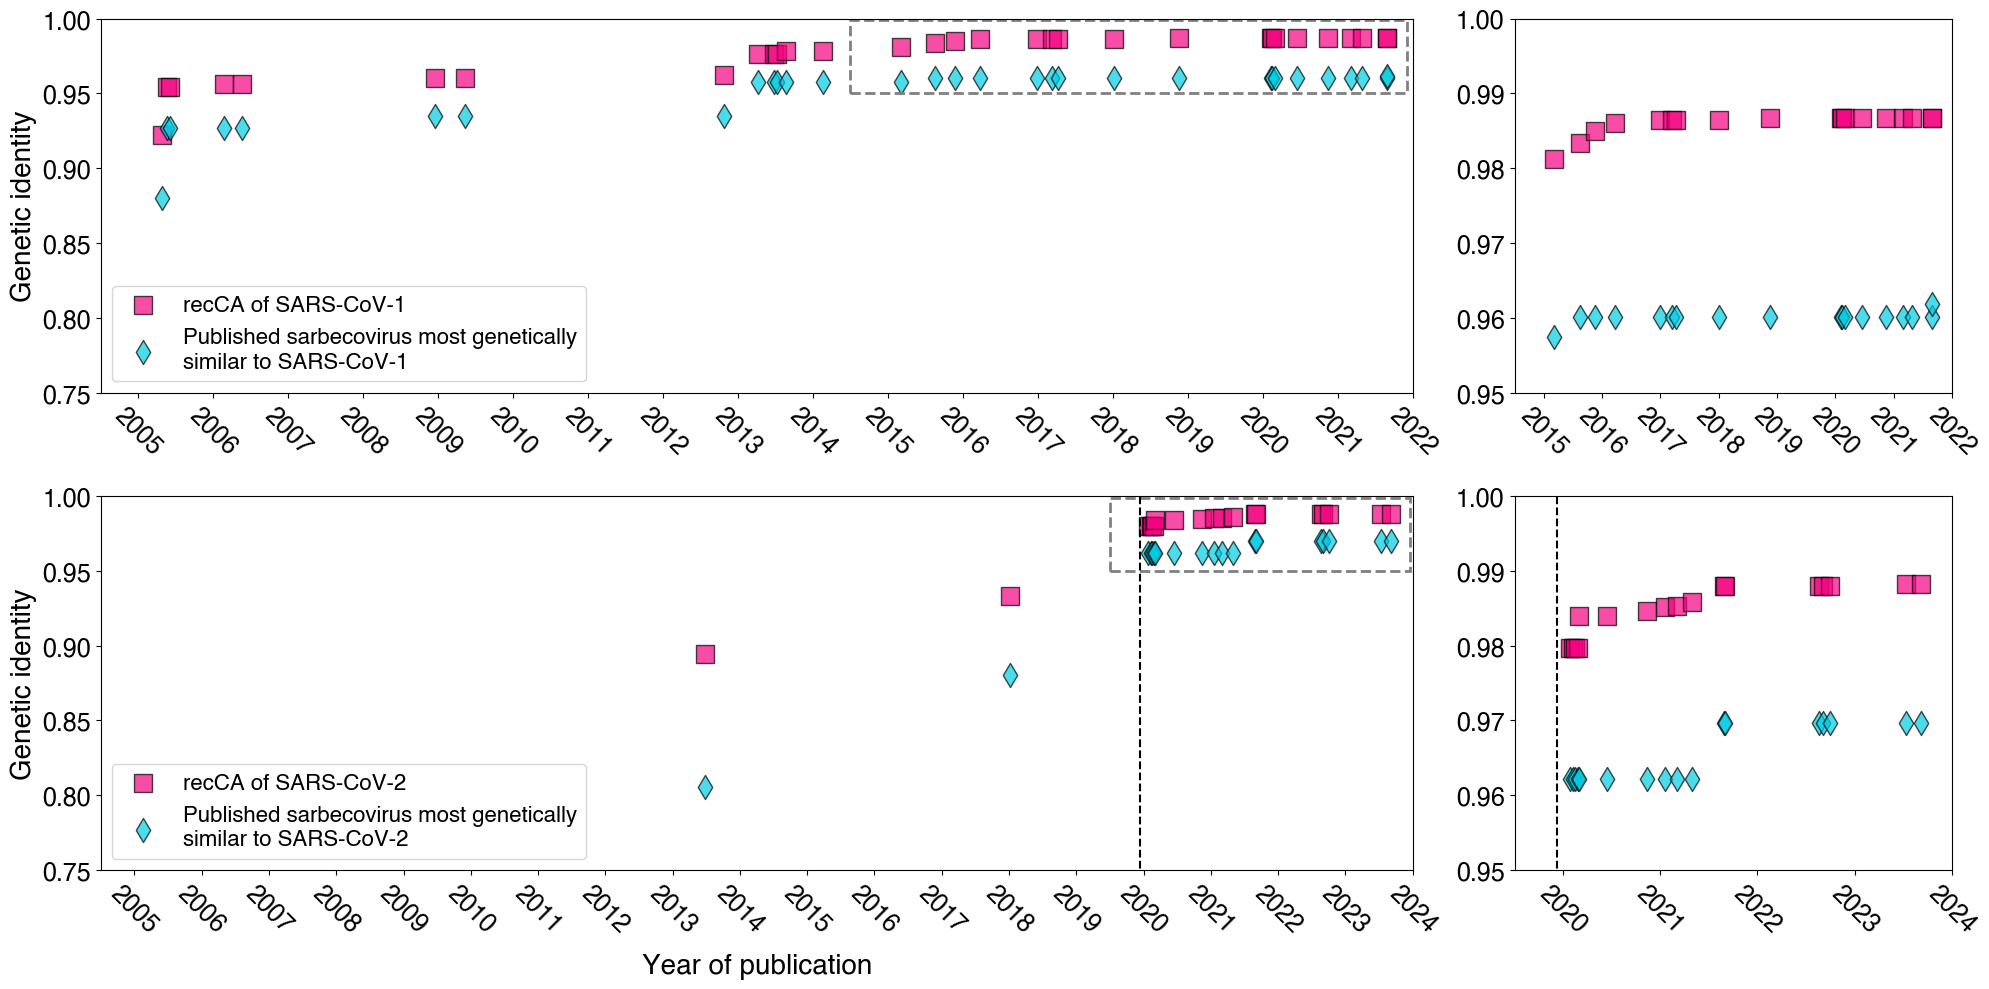

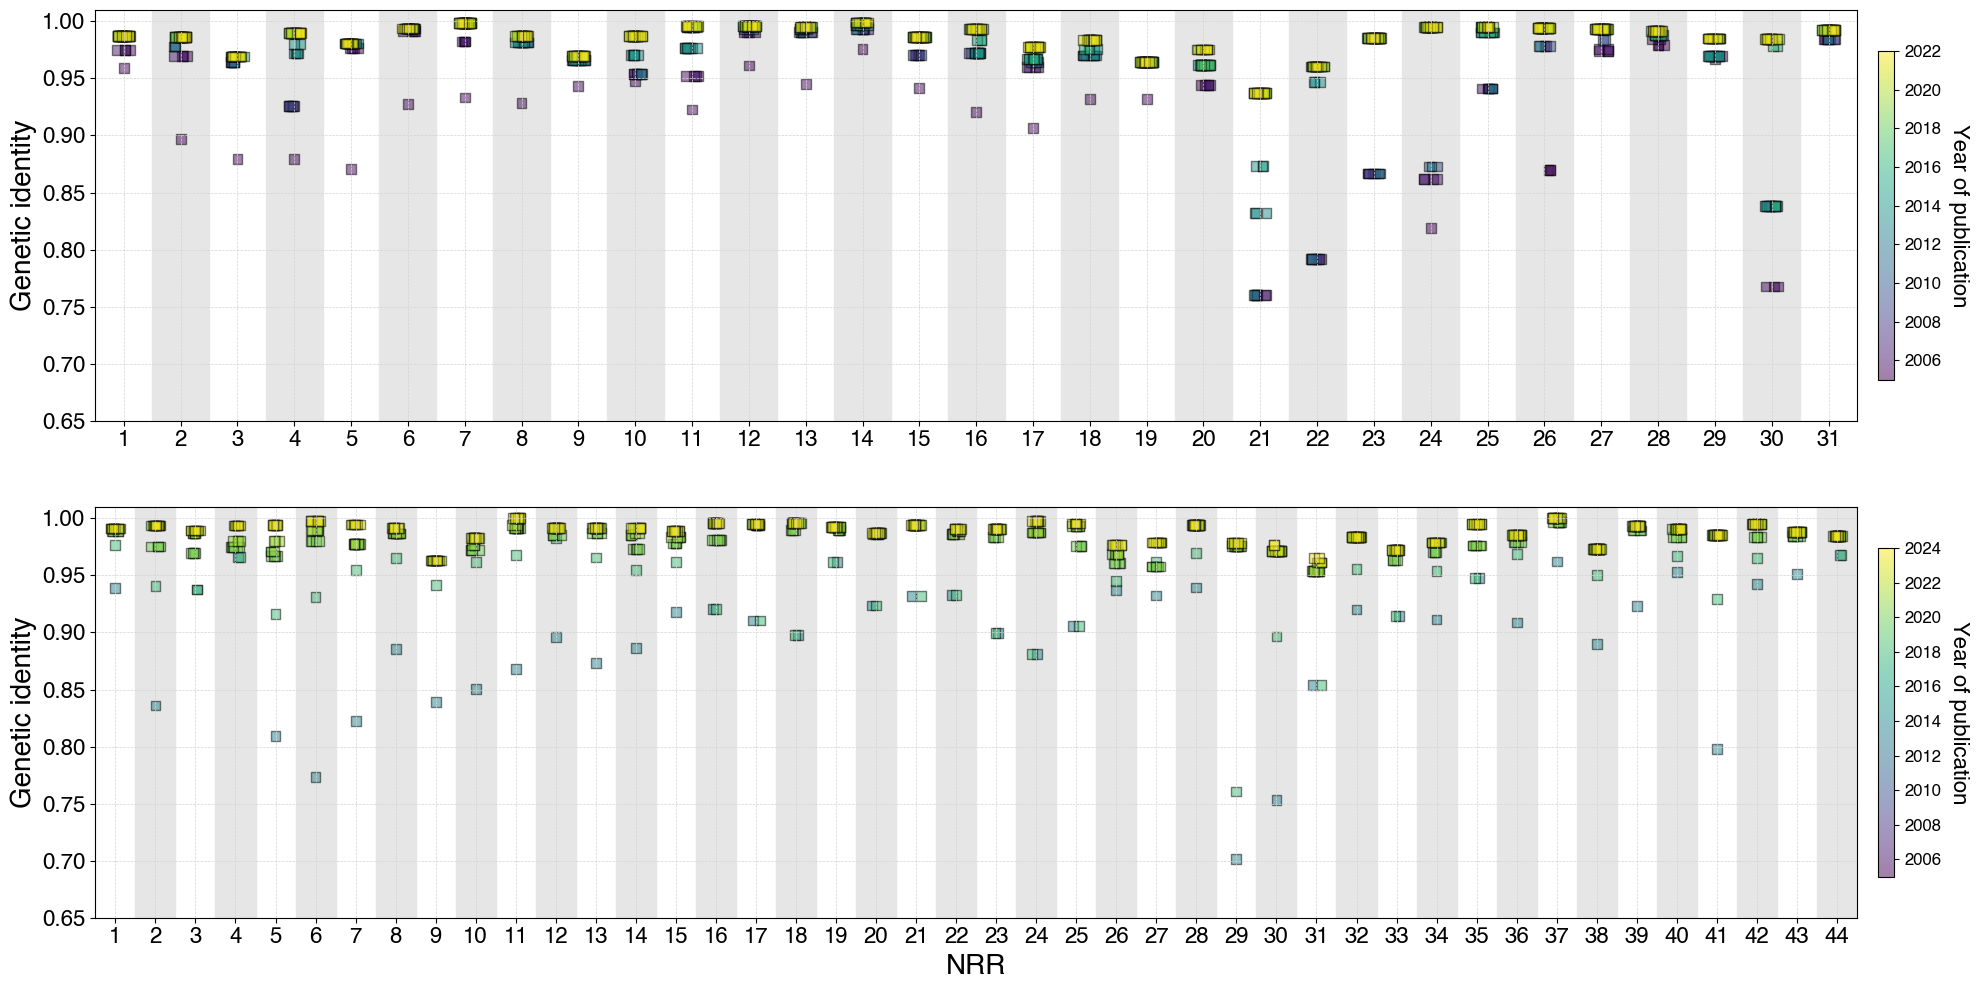

In [6]:
def recCA_over_time_plot(sc, recCA_over_time_dict, sc_similarity_over_time_dict, axes, include_xlabel=False, legend_fontsize=16):
    if sc == 1:
        first_sc_case_date = toYearFraction('2002-11-16')
        narrow_ylim = [2014.5,2022]
        narrow_xticks = np.linspace(2015,2022,8)
        wide_ylim = [2004.5,2022]
        wide_xticks = np.linspace(2005,2022,18)
        rect = patches.Rectangle((narrow_ylim[0], 0.95), (narrow_ylim[1]-narrow_ylim[0])*.99, .05*.98, linewidth=2, edgecolor='grey', linestyle='--', facecolor='none')

    else:
        first_sc_case_date = toYearFraction('2019-12-10')
        narrow_ylim = [2019.5,2024]
        narrow_xticks = np.linspace(2020,2024,5)
        wide_ylim = [2004.5,2024]
        wide_xticks = np.linspace(2005,2024,20)
        rect = patches.Rectangle((narrow_ylim[0], 0.95), (narrow_ylim[1]-narrow_ylim[0])*.99, .05*.98, linewidth=2, edgecolor='grey', linestyle='--', facecolor='none')


    x = [float(x) for x in recCA_over_time_dict.keys()]
    y_recCA = recCA_over_time_dict.values()
    y_taxon = sc_similarity_over_time_dict.values()
    axes[0].scatter(x, y_recCA, marker='s', s=150, c='#f50280', edgecolors='black', label=f'recCA of SARS-CoV-{sc}', alpha=0.7)
    axes[0].scatter(x, y_taxon, marker='d', s=150, c='#00cce3', edgecolors='black', label=f'Published sarbecovirus most genetically\nsimilar to SARS-CoV-{sc}', alpha=0.7)
    axes[0].tick_params(axis='both', which='major', labelsize=18)
    axes[0].set_xlim(wide_ylim)
    axes[0].set_xticks(ticks=wide_xticks)
    axes[0].set_ylim([0.75, 1.0])

    axes[1].scatter(x, y_recCA, marker='s', s=150, c='#f50280', edgecolors='black', label='recCA', alpha=0.7)
    axes[1].scatter(x, y_taxon, marker='d', s=150, c='#00cce3', edgecolors='black', label='most similar sampled sarbecovirus', alpha=0.7)
    axes[1].tick_params(axis='both', which='major', labelsize=18)
    axes[1].set_xlim(narrow_ylim)
    axes[1].set_xticks(ticks=narrow_xticks)
    axes[1].set_ylim([0.95, 1.0])

    # add date of emergence
    axes[0].vlines(first_sc_case_date, 0, 1, linestyle='--', color='black')
    axes[1].vlines(first_sc_case_date, 0, 1, linestyle='--', color='black')

    # Add the patch to the Axes
    axes[0].add_patch(rect)

    plt.setp(axes[0].get_xticklabels(), ha="center", rotation=-45)
    plt.setp(axes[1].get_xticklabels(), ha="center", rotation=-45)

    axes[0].legend(loc='lower left', fontsize=legend_fontsize)
    axes[0].set_ylabel('Genetic identity', fontsize=20)
    if include_xlabel:
        axes[0].set_xlabel('Year of publication', fontsize=20, labelpad=12)
        
        


def recCA_over_time_nrrs_plot(sc, sc_nrr_over_time_dict, ax, include_xlabel=False):
    if sc == 1:
        vmin = 2005
        vmax = 2022
    else:
        vmin = 2005
        vmax = 2024
        
    def jitter(nrr, y_recCA):
        counter = Counter(y_recCA)
        x = []
        for y in y_recCA:
            if counter[y] == 1:
                x.append(nrr)
            else:
                x.append(nrr + random.uniform(0, .25) - 0.125)
        return x 
    

    for nrr in sorted(sc_nrr_over_time_dict):
        # grey column for even nrrs
        if nrr % 2 == 0:
            ax.add_patch(patches.Rectangle((nrr-0.5, 0), 1, 1.05, color='0.9'))

        dates = sc_nrr_over_time_dict[nrr].keys()
        y_recCA = sc_nrr_over_time_dict[nrr].values()
        x = jitter(nrr, y_recCA)

        # create palette
        cmap = mpl.cm.viridis
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        df = pd.DataFrame({'x':x, 'y':y_recCA, 'date':dates})

        sc = ax.scatter(x, y_recCA, marker='s', s=50, c=df['date'], edgecolors='black', alpha=0.5, norm=norm, cmap=cmap)
        ax.vlines(nrr, 0, 1.1, colors='lightgrey', linestyles='dashed', linewidth=0.5)
        
    for x in np.linspace(0,1,21):
        ax.hlines(x, 0, len(sc_nrr_over_time_dict)+1, colors='lightgrey', linestyles='dashed', linewidth=0.5)

    # adjust plots
    ax.set_xticks(ticks=np.linspace(1,len(sc_nrr_over_time_dict),len(sc_nrr_over_time_dict)))
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlim([0.5, len(sc_nrr_over_time_dict)+.5])
    ax.set_ylim([0.65, 1.01])
    plt.setp(axes[0].get_xticklabels(), ha="center")
    if include_xlabel:
        ax.set_xlabel('NRR', fontsize=20)
    ax.set_ylabel('Genetic identity', fontsize=20)

    # # colorbar for this axis
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.01, shrink=0.8)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks(np.linspace(2006,vmax,(int((vmax - 2006)/2) + 1)))
    cbar.set_label('Year of publication', fontsize=16, rotation=270, labelpad=20)



f, axes = plt.subplots(2,2,figsize=(20,10),facecolor='w',gridspec_kw={'width_ratios': [3, 1]})
axes = axes.flatten()
recCA_over_time_plot(sc=1,
                     recCA_over_time_dict=sc1_complete_comparison_pureSeq,
                     sc_similarity_over_time_dict=sc1_complete_sc_similarity_over_time_pureSeq,
                     axes=axes[:2])
recCA_over_time_plot(sc=2,
                     recCA_over_time_dict=sc2_late_complete_comparison_pureSeq,
                     sc_similarity_over_time_dict=sc2_late_sc_similarity_over_time_pureSeq,
                     axes=axes[2:],
                     include_xlabel=True)

# add panel labels
# axes[0].text(-0.1, 1.2, 'a', transform=axes[0].transAxes, fontsize=34, va='top', ha='right', fontweight='bold')
# axes[2].text(-0.1, 1.2, 'b', transform=axes[2].transAxes, fontsize=34, va='top', ha='right', fontweight='bold')
plt.tight_layout(h_pad=2)
# plt.savefig('recCA_over_time.pdf', dpi=300)
plt.show()

f, axes = plt.subplots(2,1,figsize=(22,10),facecolor='w')
recCA_over_time_nrrs_plot(sc=1, sc_nrr_over_time_dict=sc1_nrr_comparisons_pureSeq, ax=axes[0])
recCA_over_time_nrrs_plot(sc=2, sc_nrr_over_time_dict=sc2_late_nrr_comparisons_pureSeq, ax=axes[1], include_xlabel=True)
# axes[0].text(-0.05, 1.2, 'c', transform=axes[0].transAxes, fontsize=34, va='top', ha='right', fontweight='bold')
# axes[1].text(-0.05, 1.2, 'd', transform=axes[1].transAxes, fontsize=34, va='top', ha='right', fontweight='bold')
plt.tight_layout(h_pad=4)
# plt.savefig('recCA_over_time_nrrs.pdf', dpi=300)

# Sensitivity analyses

### SC1 extra seqs

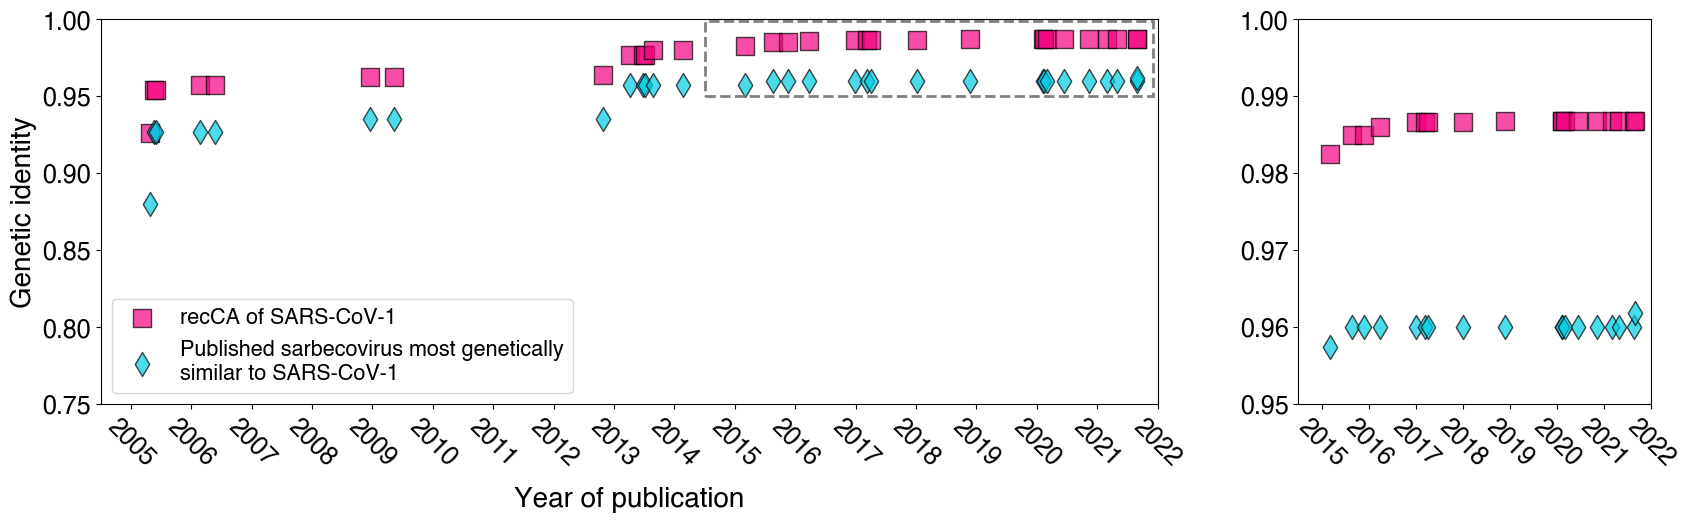

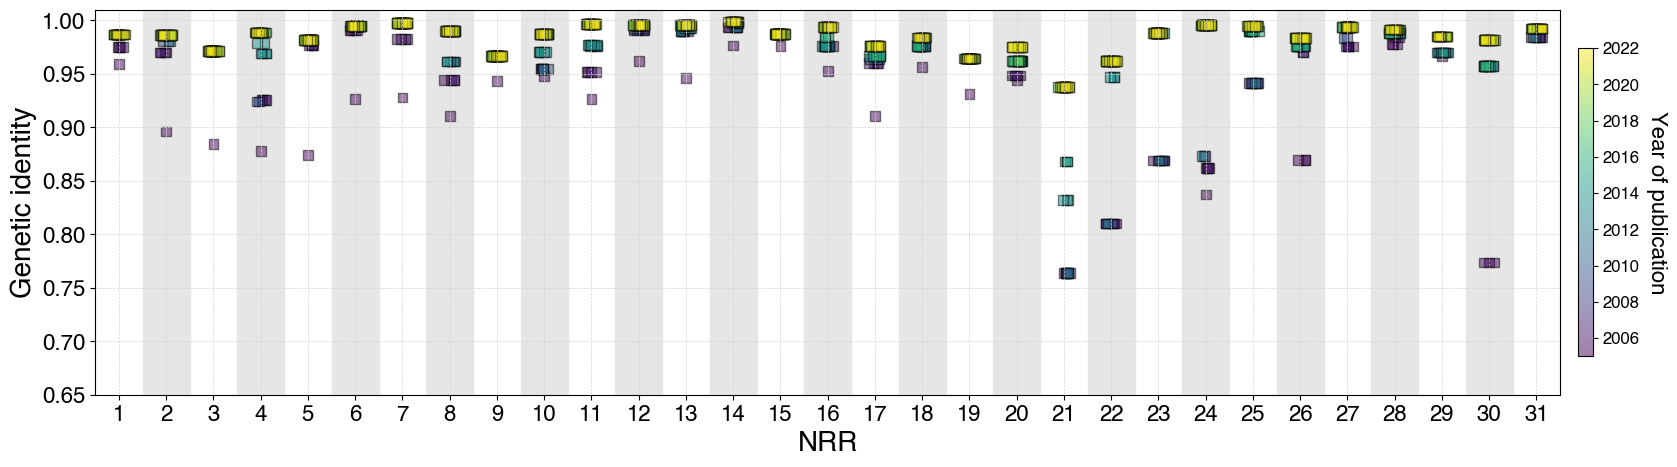

In [7]:
f, axes = plt.subplots(1,2,figsize=(20,5),facecolor='w',gridspec_kw={'width_ratios': [3, 1]})
recCA_over_time_plot(sc=1, 
                     recCA_over_time_dict=sc1_extraSeqs_complete_comparison_pureSeq, 
                     sc_similarity_over_time_dict=sc1_extraSeqs_complete_sc_similarity_over_time_pureSeq,
                     axes=axes, 
                     legend_fontsize=15.5,
                        include_xlabel=True)
plt.show()
f, ax = plt.subplots(1,1,figsize=(22.5,5),facecolor='w')
recCA_over_time_nrrs_plot(sc=1, sc_nrr_over_time_dict=sc1_extraSeqs_nrr_comparisons_pureSeq, ax=ax, include_xlabel=True)

### SC2 early 2020 prior

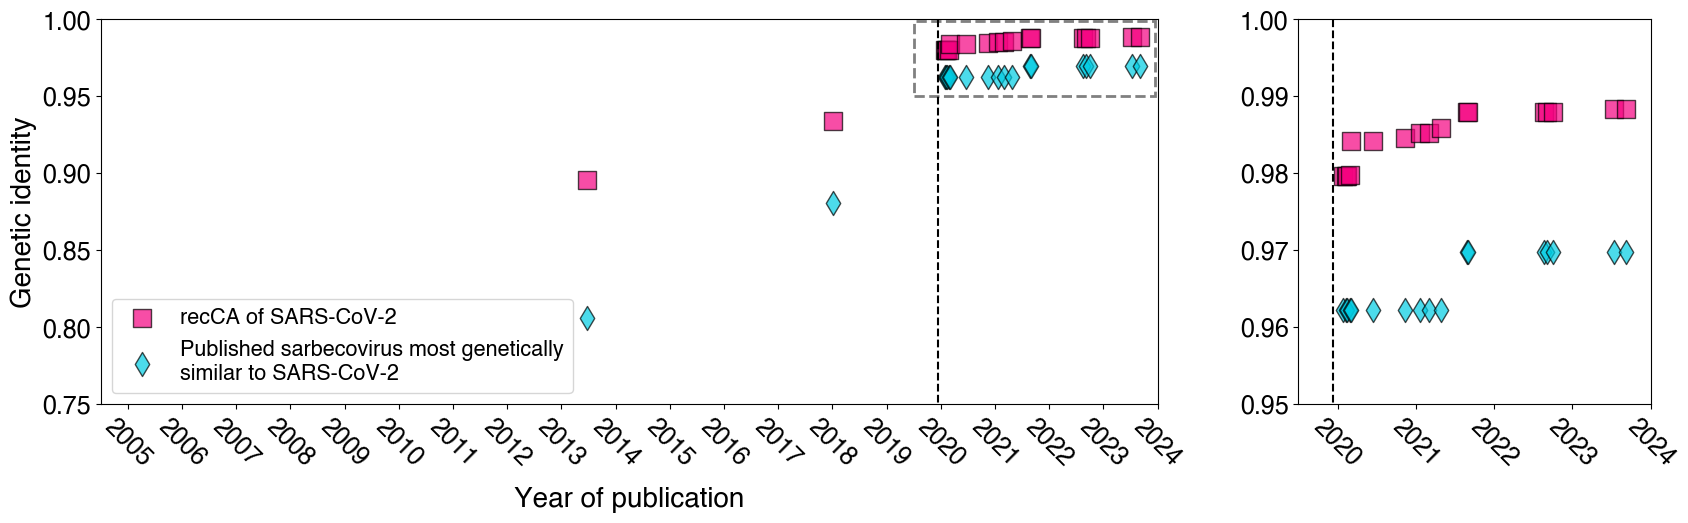

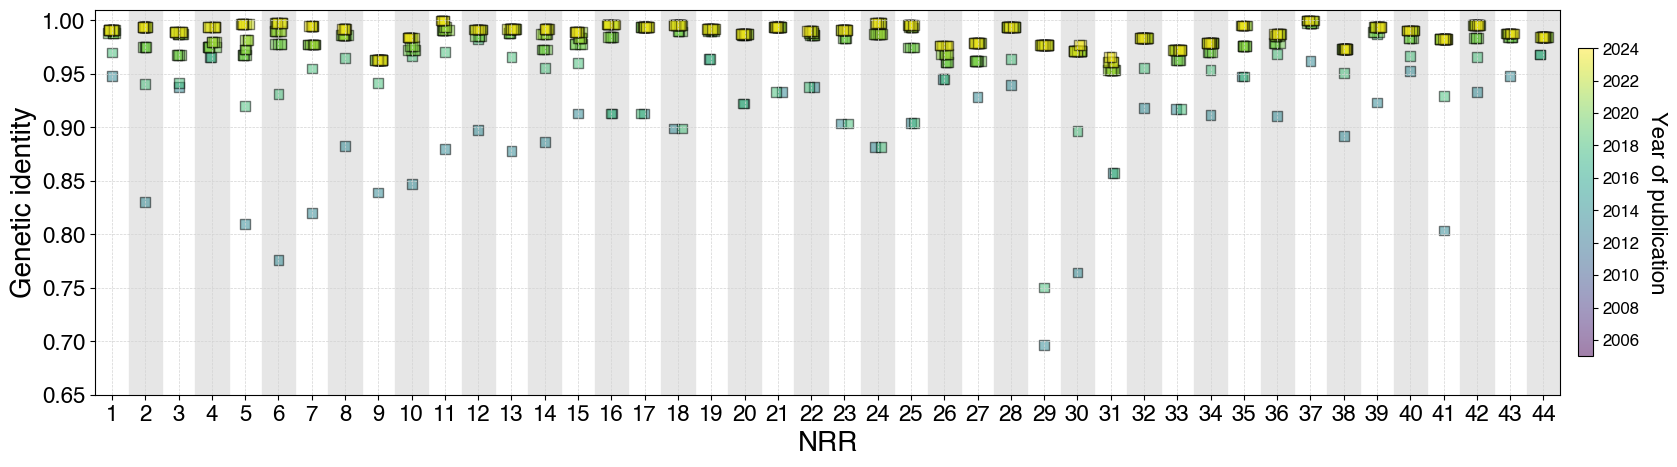

In [8]:
f, axes = plt.subplots(1,2,figsize=(20,5),facecolor='w',gridspec_kw={'width_ratios': [3, 1]})
recCA_over_time_plot(sc=2, 
                     recCA_over_time_dict=sc2_early_complete_comparison_pureSeq, 
                     sc_similarity_over_time_dict=sc2_early_sc_similarity_over_time_pureSeq,
                     axes=axes, 
                     legend_fontsize=15.5, 
                     include_xlabel=True)
plt.show()
f, ax = plt.subplots(1,1,figsize=(22.5,5),facecolor='w')
recCA_over_time_nrrs_plot(sc=2, sc_nrr_over_time_dict=sc2_early_nrr_comparisons_pureSeq, ax=ax, include_xlabel=True)